In [22]:
# Biblioteki

import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning

In [23]:
# Konfiguracja

warnings.filterwarnings("ignore", category=ValueWarning)

# Wskaźniki
indicators = {
    'nrg_ind_ren': 'OZE_Share',           # Udział OZE w końcowym zużyciu energii [%]
    'nrg_ind_ei':  'Energy_Intensity',    # Energochłonność (kgoe / 1000 EUR)
    'nrg_ind_id':  'Import_Dependency',   # Zależność importowa [%]
}

# Statystyki balansu energetycznego
stats = {
    "nrg_ind_ren": {"nrg_bal": "REN"},           # ogólnie (bez podziału transport, elektryczność itp.)
    "nrg_ind_ei":  {"nrg_bal": "EI_GDP_PPS"}, # w standardzie siły nabywczej
    "nrg_ind_id": {'siec':  'TOTAL'}   # Całkowita (bez podziału węgiel itp.)
}

# Określenie charakteru zmiennych
# S - Stymulanta, D - Destymulanta
variable_types = {
    'OZE_Share': 'S',
    'Energy_Intensity': 'D',
    'Import_Dependency': 'D',
}

GEO = 'PL'

In [5]:
def fetch_and_clean(code, name, geo, stats = stats):
    df = eurostat.get_data_df(code)
    df = df[df['geo\\TIME_PERIOD'] == geo]
    
    key = list(stats[code].keys())[0]
    value = list(stats[code].values())[0]
    df = df[df[key] == value]
            
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df = df[year_cols]
    
    df = df.T
    df.columns = [name]
    df.index.name = 'Rok'
    df.index = df.index.astype(int)
    df = df.sort_index()
    
    return df

In [6]:
# Pobieranie danych
print("Łączenie z API Eurostat...")

dfs = []
for code, name in indicators.items():
    print(f"  - Pobieranie: {name} ({code})")
    d = fetch_and_clean(code, name, GEO)
    dfs.append(d)

data = pd.concat(dfs, axis=1).dropna()
print(f"\nZgromadzono dane dla lat: {data.index.min()} - {data.index.max()}")
print(data.head())
print('Liczba obserwacji:', len(data))
print('Liczba zmiennych diagnostycznych:', len(data.columns))

Łączenie z API Eurostat...
  - Pobieranie: OZE_Share (nrg_ind_ren)
  - Pobieranie: Energy_Intensity (nrg_ind_ei)
  - Pobieranie: Import_Dependency (nrg_ind_id)

Zgromadzono dane dla lat: 2004 - 2023
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004      6.882            219.23             14.727
2005      6.867            213.32             17.748
2006      6.859            212.21             20.149
2007      6.903            192.31             25.790
2008      7.686            181.36             30.862
Liczba obserwacji: 20
Liczba zmiennych diagnostycznych: 3


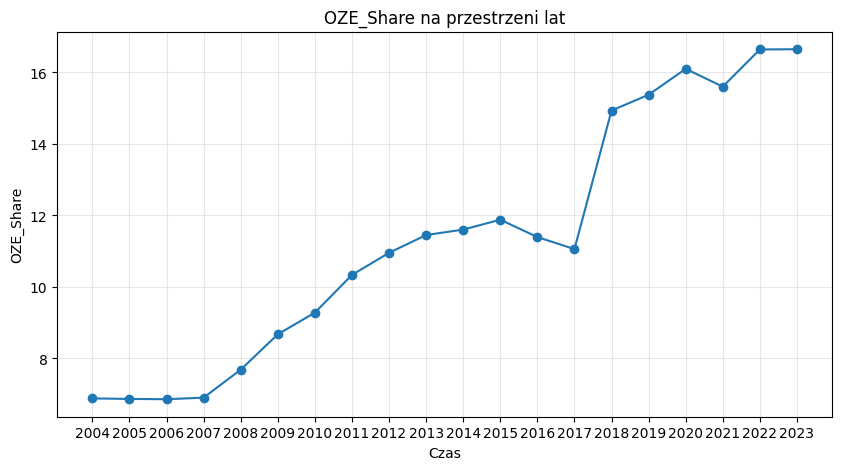

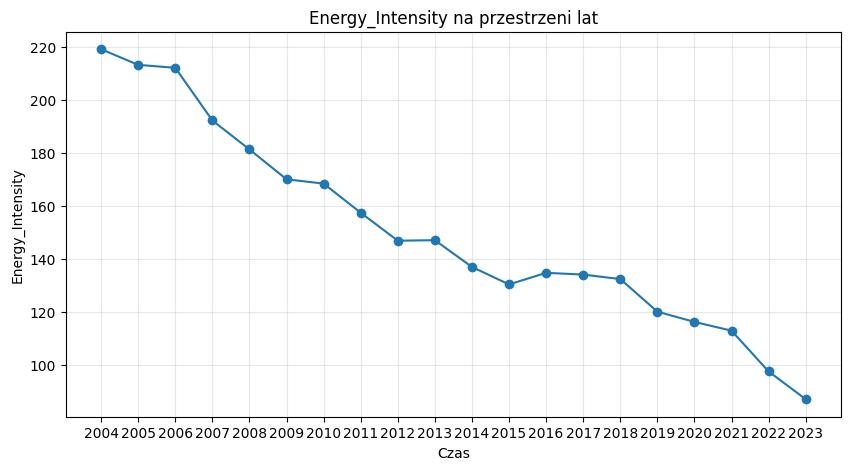

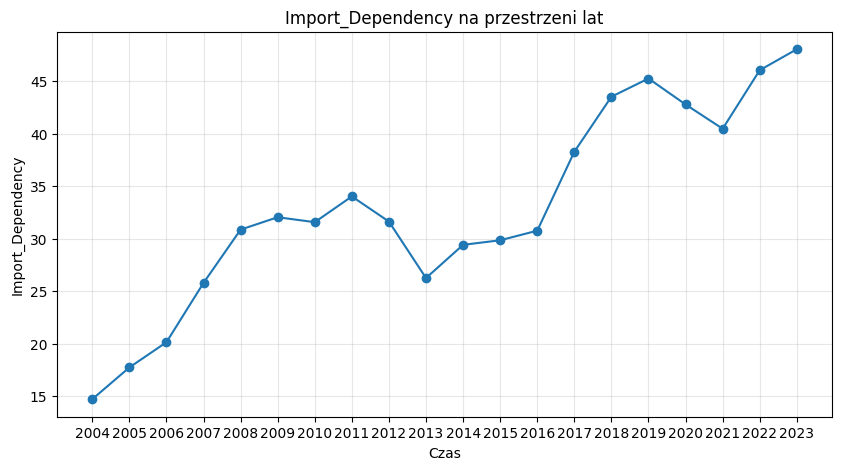

In [7]:
for _, v in indicators.items():
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data[v], marker='o')
    plt.title(f'{v} na przestrzeni lat')
    plt.xlabel('Czas')
    plt.ylabel(v)
    plt.xticks(range(data.index.min(), data.index.max() + 1))
    plt.grid(alpha=0.3)
    plt.show()


In [8]:
# Zamiana destymulant na stymulanty - czy potrzebne
for col, v_type in variable_types.items():
    if col in data.columns and v_type == 'D':
        data[col] = -1 * data[col]

In [9]:
# 3. Standaryzacja (z-score) i podgląd
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
print('\nPrzykładowe wiersze po standaryzacji:')
print(df_std.head())


Przykładowe wiersze po standaryzacji:
      OZE_Share  Energy_Intensity  Import_Dependency
Rok                                                 
2004  -1.313056         -1.844228           1.976081
2005  -1.317457         -1.685605           1.648579
2006  -1.319804         -1.655813           1.388290
2007  -1.306896         -1.121702           0.776758
2008  -1.077181         -0.827806           0.226910


In [10]:
# 4. Konstrukcja indeksów agregatowych
# --- a) Equal Weighting (srednia standaryzowanych)
data["equal_weighting"] = df_std.mean(axis=1)


In [11]:
# --- b) PCA (główna składowa) standaryzowanych
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_std)

data['PCA'] = pca_result

In [12]:
# --- c) Entropy Weighting Method (normalizacja MinMax)
minmax = MinMaxScaler()
df_norm = pd.DataFrame(minmax.fit_transform(data[indicators.values()]), columns=indicators.values(), index=data.index)

P = df_norm / (df_norm.sum(axis=0) + 1e-8)
P = np.where(P == 0, 1e-10, P)
E = (-P * np.log(P)).mean(axis=0) / np.log(len(data))
d = 1 - E
ewm_weights = d / d.sum()
data["entropy_weighting"] = (df_norm * ewm_weights).sum(axis=1)

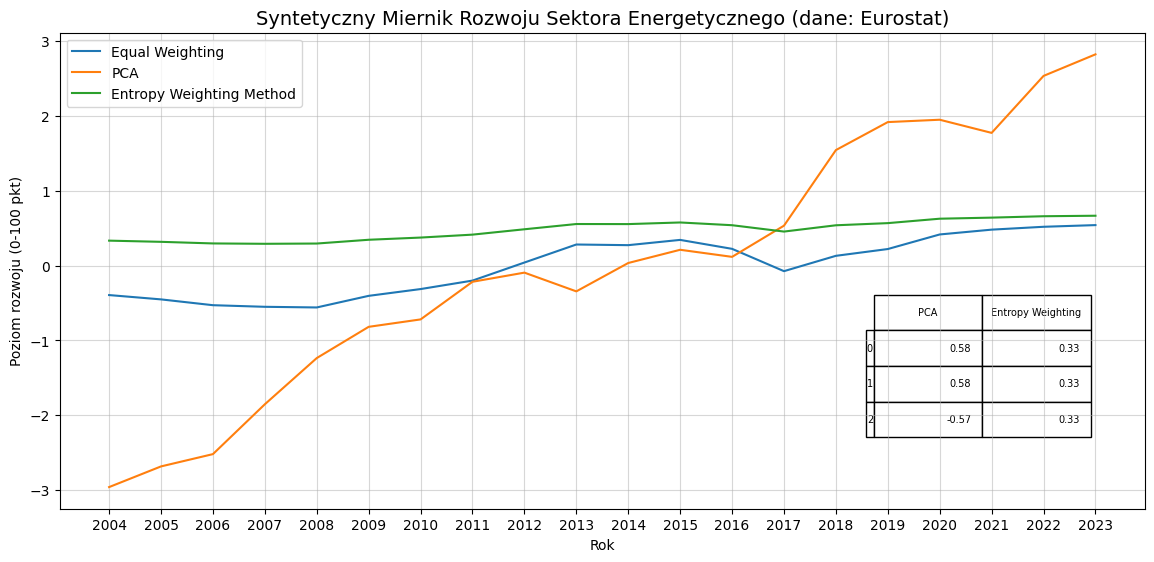

In [13]:
plt.figure(figsize=(14, 7))

# Wykres główny
sns.lineplot(x=data.index, y=data['equal_weighting'], label='Equal Weighting')
sns.lineplot(x=data.index, y=data['PCA'], label='PCA')
sns.lineplot(x=data.index, y=data['entropy_weighting'], label='Entropy Weighting Method')

plt.title(f'Syntetyczny Miernik Rozwoju Sektora Energetycznego (dane: Eurostat)', fontsize=14)
plt.ylabel('Poziom rozwoju (0-100 pkt)')
plt.xlabel('Rok')
plt.xticks(range(data.index.min(), data.index.max() + 1))
plt.legend()


# Tabela z wagami (ładunki czynnikowe)
indicator_cols = list(indicators.values())
loadings = pd.DataFrame(
    {
        'PCA': pca.components_[0],
        'Entropy Weighting': ewm_weights
    }
)

plt.table(cellText=np.round(loadings.values, 2),
          rowLabels=loadings.index,
          colLabels=loadings.columns,
          loc='bottom', bbox=[0.75, 0.15, 0.2, 0.3])
plt.subplots_adjust(bottom=0.2)
plt.grid(True, which='major', alpha=0.5)

plt.show()

In [14]:
# 5. Analiza mozliwosci Random Forest
trend = data['equal_weighting'].rolling(window=8, min_periods=1).mean().corr(pd.Series(np.arange(len(data['equal_weighting'])), index=data['equal_weighting'].index))
if len(data) < 100 and abs(trend) > 0.4:
    print("\nUWAGA: Liczba obserwacji < 100 i obecny silny trend. NIE zaleca się metody Random Forest do prognozowania tych szeregów.")
else:
    print("\nRandom Forest może byc potencjalnie wykorzystany (liczba obserwacji i/lub trend nie zaburzają uczenia).")


UWAGA: Liczba obserwacji < 100 i obecny silny trend. NIE zaleca się metody Random Forest do prognozowania tych szeregów.


In [15]:
# 6. Podział na okres treningowy+test+prognoza
steps_ahead = 2
train = df_std.iloc[:-steps_ahead]
test = df_std.iloc[-steps_ahead:]

print(f'\nLiczba obserwacji w zbiorze treningowym: {len(train)}')
print(f'Liczba obserwacji w zbiorze testowym: {len(test)}')


Liczba obserwacji w zbiorze treningowym: 18
Liczba obserwacji w zbiorze testowym: 2


In [ ]:
# 7. Bezpośrednia prognoza indeksu agregatowego
def eval_metrics(actual, pred):
    me = np.mean(pred - actual)
    mpe = 100*np.mean((pred - actual) / actual)
    mae = np.mean(np.abs(pred - actual))
    mape = 100*np.mean(np.abs((pred - actual) / actual))
    rmse = np.sqrt(np.mean((pred - actual) ** 2))
    rmspe = 100 * (rmse / np.mean(actual)) if np.mean(actual) != 0 else np.nan
    t = np.sqrt(np.mean(((pred[1:] - actual[1:])**2)) / np.mean((actual[1:]**2)))
    return {'ME': me, 'MPE': mpe, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'RMSPE': rmspe, 'Theil': t}


def best_time_model(series, horizon, models_config):
    min_rmspe = float('inf')
    best_pred = None
    best_model_name = "Fallback (Last Value)" # Domyślna nazwa w razie błędu

    print(f"\n--- Rozpoczynam trenowanie {len(models_config)} modeli ---")

    # Iteracja po słowniku modeli
    for name, (func, params) in models_config.items():
        pred, _, metric = func(series, horizon, **params)
        
        # Sprawdzenie czy model zwrócił wynik (czy nie było wyjątku)
        if pred is not None and metric is not None:
            print(f"Model: {name:20} | RMSPE: {metric:.4f}%")
            
            # Jeśli błąd jest mniejszy niż dotychczasowy najlepszy -> aktualizujemy
            if metric < min_rmspe:
                min_rmspe = metric
                best_pred = pred
                best_model_name = name
            else:
                print(f"Model: {name:20} | brak konwergencji")
        else:
            print(f"Model: {name:20} | BŁĄD")

    # Obsługa przypadku, gdy wszystkie modele zawiodły (Fallback)
    if best_pred is None or np.isnan(best_pred).any():
        print(f"\nWARNING: Wszystkie modele zawiodły. Używam fallback.")
        fallback_value = series.dropna().iloc[-1] if not series.dropna().empty else 0
        best_pred = np.full(horizon, fallback_value)
    else:
        print(f"\n>>> ZWYCIĘZCA: {best_model_name} (RMSPE: {min_rmspe:.4f}%)")

    return best_pred, best_model_name


In [17]:
def OLS(series, horizon):
    s = series.dropna()
    try:
        X = np.arange(len(s))
        X_mat = X[:,None]
        model = sm.OLS(s.values, sm.add_constant(X_mat)).fit()
        exog_pred = np.arange(len(s), len(s)+horizon)[:,None]
        ols_pred = model.predict(sm.add_constant(exog_pred))
        rmspe_ols = 100*np.sqrt(np.mean(((model.fittedvalues - s.values)/s.values)**2))
        return ols_pred, 'OLS trend', rmspe_ols
    except Exception as e:
        print(f"OLS model error: {e}")
        return None, None, None
    
def Holt_Winters(series, horizon):
    s = series.dropna()
    try:
        hw = ExponentialSmoothing(s, trend='add').fit()
        hw_pred = hw.forecast(horizon)
        rmspe_hw = 100*np.sqrt(np.mean(((hw.fittedvalues - s.values) / s.values) ** 2))
        return hw_pred, 'Holt-Winters', rmspe_hw
    except Exception as e:
        print(f"Holt-Winters model error: {e}")
        return None, None, None
    
def SARIMA(series, horizon, AR=1, I=1, MA=1):
    s = series.dropna()
    try:
        sarima = SARIMAX(s, order=(AR, I, MA)).fit(disp=False)
        sarima_pred = sarima.forecast(horizon)
        rmspe_sarima = 100*np.sqrt(np.mean(((sarima.fittedvalues - s.values) / s.values) ** 2))
        return sarima_pred, 'SARIMA', rmspe_sarima
    except Exception as e:
        print(f"SARIMA model error: {e}")
        return None, None, None

In [19]:
# MODELS CONFIG
models_to_test = {
    'OLS_Trend': (OLS, {}),
    'Holt_Winters': (Holt_Winters, {}),
    'SARIMA_0_1_0': (SARIMA, {'AR': 0, 'I': 1, 'MA': 0}),
    'SARIMA_Default': (SARIMA, {'AR': 1, 'I': 1, 'MA': 1}),
    'SARIMA_1_1_0': (SARIMA, {'AR': 1, 'I': 1, 'MA': 0}),
    'SARIMA_2_1_2': (SARIMA, {'AR': 2, 'I': 1, 'MA': 2})
}


>>> Prognozy BEZPOŚREDNIE indeksów na 2 lata do przodu <<<

[EW] Model: OLS trend (Forced)
Miary trafności: {'ME': np.float64(0.018102554274013694), 'MPE': np.float64(3.3379128560272266), 'MAE': np.float64(0.01915215898454775), 'MAPE': np.float64(3.5400673182432065), 'RMSE': np.float64(0.026353513333386966), 'RMSPE': np.float64(4.968324408834436), 'Theil': np.float64(0.06877980174270433)}


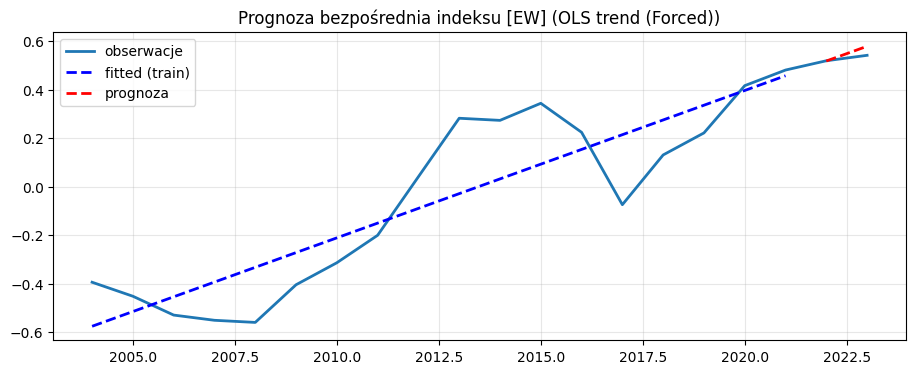


--- Rozpoczynam trenowanie 6 modeli ---
Model: OLS_Trend            | RMSPE: 169.5248%
Model: Holt_Winters         | RMSPE: 118.9941%
Model: SARIMA_0_1_0         | RMSPE: 268.1157%
Model: SARIMA_0_1_0         | brak konwergencji
Model: SARIMA_Default       | RMSPE: 354.7991%
Model: SARIMA_Default       | brak konwergencji
Model: SARIMA_1_1_0         | RMSPE: 357.7933%
Model: SARIMA_1_1_0         | brak konwergencji


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling

Model: SARIMA_2_1_2         | RMSPE: 152.8746%
Model: SARIMA_2_1_2         | brak konwergencji

>>> ZWYCIĘZCA: Holt_Winters (RMSPE: 118.9941%)

[PCA] Najlepszy model: Holt_Winters
Miary trafności: {'ME': nan, 'MPE': nan, 'MAE': nan, 'MAPE': nan, 'RMSE': np.float64(nan), 'RMSPE': np.float64(nan), 'Theil': np.float64(nan)}


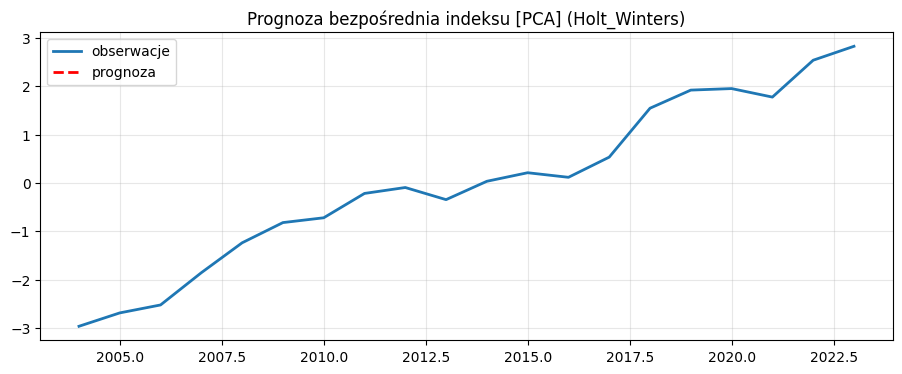


--- Rozpoczynam trenowanie 6 modeli ---
Model: OLS_Trend            | RMSPE: 11.7148%
Model: Holt_Winters         | RMSPE: 9.2317%
Model: SARIMA_0_1_0         | RMSPE: 25.3786%
Model: SARIMA_0_1_0         | brak konwergencji
Model: SARIMA_Default       | RMSPE: 25.1644%
Model: SARIMA_Default       | brak konwergencji
Model: SARIMA_1_1_0         | RMSPE: 25.1648%
Model: SARIMA_1_1_0         | brak konwergencji


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling

Model: SARIMA_2_1_2         | RMSPE: 24.9172%
Model: SARIMA_2_1_2         | brak konwergencji

>>> ZWYCIĘZCA: Holt_Winters (RMSPE: 9.2317%)

[EWM] Najlepszy model: Holt_Winters
Miary trafności: {'ME': nan, 'MPE': nan, 'MAE': nan, 'MAPE': nan, 'RMSE': np.float64(nan), 'RMSPE': np.float64(nan), 'Theil': np.float64(nan)}


c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\norbe\OneDrive\Desktop\Studia\Magisterskie\Zaawansowane metody prognozowania\PrognozowanieSektoraEnergetycznego\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


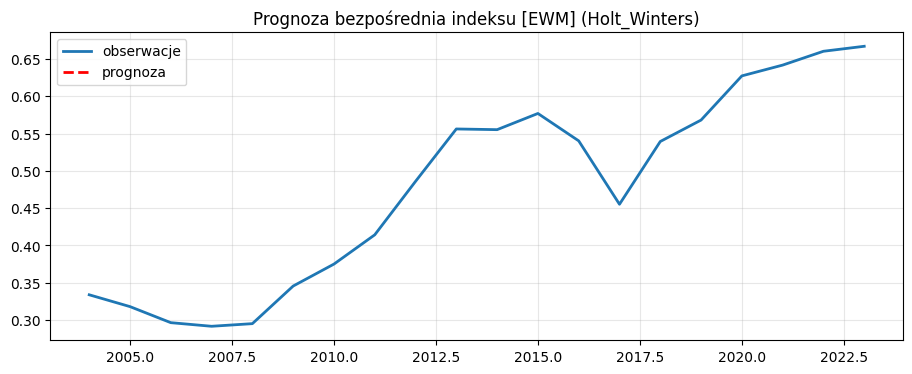


PODSUMOWANIE MIAR TRAFNOŚCI PROGNOZ (OKRES TESTOWY - Prognoza bezpośrednia):


,ME,MPE,MAE,MAPE,RMSE,RMSPE,Theil
EW (Direct - OLS),0.0181,3.3379,0.0192,3.5401,0.0264,4.9683,0.0688
PCA (Direct - Holt_Winters),NaN,NaN,NaN,NaN,NaN,NaN,NaN
EWM (Direct - Holt_Winters),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
print('\n>>> Prognozy BEZPOŚREDNIE indeksów na 2 lata do przodu <<<')
method_labels = {'EW': data['equal_weighting'], 'PCA': data['PCA'], 'EWM': data['entropy_weighting']}
direct_metrics = {}
for met, idx in method_labels.items():
    idx_train = idx.iloc[:-steps_ahead]
    idx_test = idx.iloc[-steps_ahead:]

    # --- Explicitly use OLS with seasonal dummies for EW index
    if met == 'EW':
        model_name = 'OLS trend (Forced)'
        try:
            X_train = np.arange(len(idx_train))
            dummies_train = None
            X_train_mat = np.column_stack([X_train, dummies_train.values]) if dummies_train is not None else X_train[:,None]
            ols_model = sm.OLS(idx_train.values, sm.add_constant(X_train_mat)).fit()
            fitted_train = pd.Series(ols_model.fittedvalues, index=idx_train.index)


            exog_pred = np.column_stack([np.arange(len(idx_train), len(idx_train)+steps_ahead),
                                        np.eye(dummies_train.shape[1])[
                                            [i%dummies_train.shape[1] for i in range(len(idx_train), len(idx_train)+steps_ahead)]
                                        ]]) if dummies_train is not None else np.arange(len(idx_train), len(idx_train)+steps_ahead)[:,None]
            fc_array = ols_model.predict(sm.add_constant(exog_pred))
            fc = pd.Series(fc_array, index=idx_test.index)
            metrics = eval_metrics(idx_test, fc)
            direct_metrics[f'{met} (Direct - OLS)'] = metrics
            print(f'\n[{met}] Model: {model_name}\nMiary trafności:', metrics)


        except Exception as e:
            print(f"\n[{met}] OLS model fitting failed: {e}")
            fc = pd.Series(np.nan, index=idx_test.index)
            fitted_train = pd.Series(np.nan, index=idx_train.index)
            direct_metrics[f'{met} (Direct - OLS)'] = {'ME': np.nan, 'MPE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 'RMSE': np.nan, 'RMSPE': np.nan, 'Theil': np.nan}


    else:
        # wybór najlepszego modelu
        fc_array, model_name = best_time_model(idx_train, steps_ahead, models_to_test)
        fc = pd.Series(fc_array, index=idx_test.index) # Convert to Series and assign index
        metrics = eval_metrics(idx_test, fc)
        direct_metrics[f'{met} (Direct - {model_name})'] = metrics
        print(f'\n[{met}] Najlepszy model: {model_name}\nMiary trafności:', metrics)


        # Get fitted values for training period (if model was not Fallback)
        fitted_train = None
        try:
            if re.match(r'^OLS', model_name):
                 X = np.arange(len(idx_train))
                 dummies = None
                 X_mat = np.column_stack([X, dummies.values]) if dummies is not None else X[:,None]
                 model = sm.OLS(idx_train.values, sm.add_constant(X_mat)).fit()
                 fitted_train = pd.Series(model.fittedvalues, index=idx_train.index)
            elif re.match(r'^Holt-Winters', model_name):
                 hw = ExponentialSmoothing(idx_train, trend='add', seasonal='add', seasonal_periods=4 if freq == 'Q' else 12).fit()
                 fitted_train = pd.Series(hw.fittedvalues, index=idx_train.index)
            elif re.match(r'^SARIMA', model_name):
                 sarima = SARIMAX(idx_train, order=(1,1,1), seasonal_order=(1,1,1, 4 if freq == 'Q' else 12)).fit(disp=False)
                 fitted_train = pd.Series(sarima.fittedvalues, index=idx_train.index)
            # Fallback models don't have fitted values in the same way, skip plotting for now
            elif model_name == "Fallback (Last Value or Mean)":
                 pass # Do not plot fitted values for fallback
        except Exception as e:
            print(f"Could not get fitted values for {met} ({model_name}): {e}")
            fitted_train = None


    plt.figure(figsize=(11,4))
    plt.title(f'Prognoza bezpośrednia indeksu [{met}] ({model_name})')
    plt.plot(idx, label='obserwacje', lw=2)
    if fitted_train is not None:
        plt.plot(idx_train.index, fitted_train, 'b--', label='fitted (train)', lw=2)
    plt.plot(idx_test.index, fc, 'r--', label='prognoza', lw=2)
    plt.legend(); plt.grid(alpha=0.3); plt.show()
    # plt.xticks(range(data.index.min(), data.index.max() + 1))


# Display direct metrics in a table
print('\n===============================')
print('PODSUMOWANIE MIAR TRAFNOŚCI PROGNOZ (OKRES TESTOWY - Prognoza bezpośrednia):')
direct_metrics_df = pd.DataFrame(direct_metrics).T.map(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)
display(direct_metrics_df)


In [ ]:
# TODO: Wybór dodadkowych składowych (1 - 3)
# TODO: Poprawić Bezpośrednia prognoza indeksu syntetycznego (np. metody ARIMA/SARIMA, Holt-Winters, ekonometryczny trend sezonowy, Random Forest, jeśli spełnione są warunki stosowania).

# TODO: Prognozowanie składników bazowych osobno, a następnie ich agregacja (te same metody, wybór najlepszej dla każdego składnika na podstawie RMSPE).
# TODO: Porównanie skuteczności obu podejść.

# Wizualizacja i raport (8-10 stron w formacie .pdf przesłany na eNauczaniu) 
